In [1]:
import pandas as pd
import numpy as np
# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 100)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 12

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 1)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR

from sklearn.neighbors.nearest_centroid import NearestCentroid

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import confusion_matrix

import pandas.core.algorithms as algos

In [2]:
df = pd.read_csv('RatingData/cs-training.csv').drop('Unnamed: 0', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [3]:
X = df.drop(['SeriousDlqin2yrs'], axis = 1)
y = df['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

print(X_train.shape,  X_test.shape)

(100500, 10) (49500, 10)


In [4]:
# Skapar WOE-data
data_train_comb = pd.concat((X_train, y_train), axis = 1)

%run woe_iv.py
final_iv, IV = data_vars(data_train_comb,data_train_comb.SeriousDlqin2yrs)

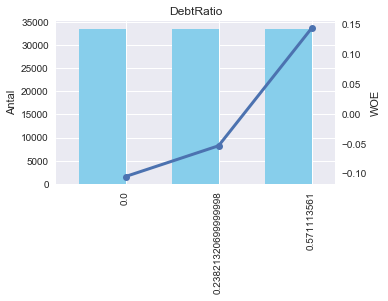

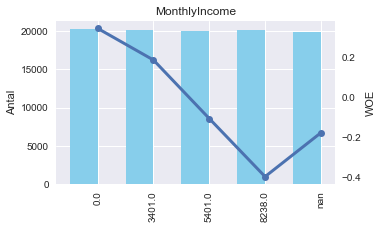

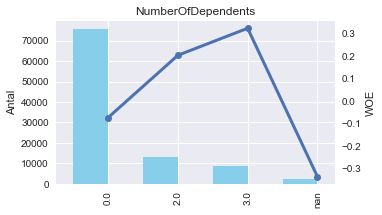

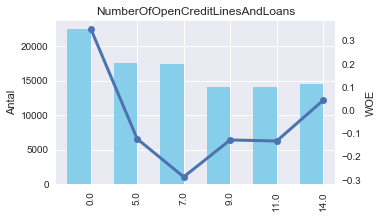

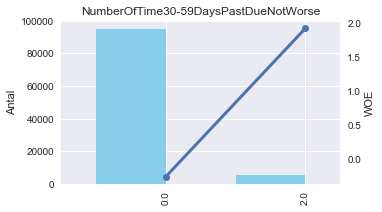

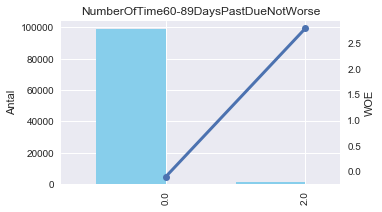

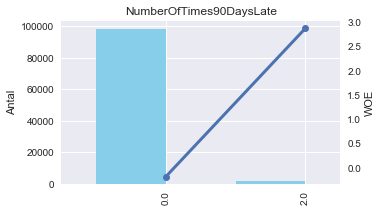

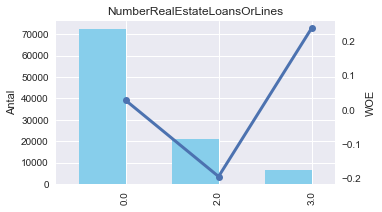

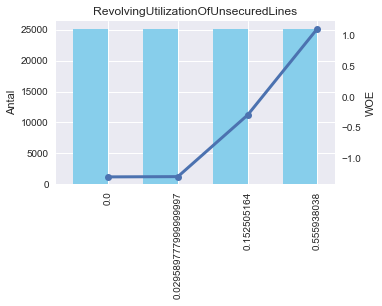

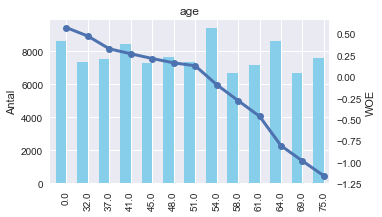

In [5]:
# Skapar grafer med WOE
def plot(df,name):
    
    fig, ax1 = plt.subplots(figsize=(5, 3))
    g = df[df['VAR_NAME'] == name]
    label = np.unique(list(g['MIN_VALUE']))

    plt.title(name)
    ax1 = g['COUNT'].plot(kind='bar', width=0.5, position=1, color='skyblue', use_index=True)
    plt.ylabel("Antal")
    ax1.set_xticklabels((label))
    ax2 =  plt.twinx(ax1)
    ax2.plot(ax1.get_xticks(),g['WOE'].values, linestyle='-', marker='o', linewidth=3.0)
    plt.ylabel("WOE")
    plt.grid(False)
     
NameList = np.unique(list(final_iv['VAR_NAME']))

for x in range(len(NameList)):
    
    factor = NameList[x]    

    plot(final_iv, factor)

In [6]:
def CreateWoeCols(data):

    concat_df = pd.DataFrame(data)
    
    name = np.unique(list(final_iv['VAR_NAME']))
               
    for x in range(len(name)):
        factor = name[x]
        woe_name = factor+'_woe'
        
        select = final_iv['VAR_NAME'] == factor
        min_values = list(final_iv['MIN_VALUE'][select])
        min_values.extend([9999999999999])
        min_values.sort()
        min_values[0] = -9999999999999
        woe = list(final_iv['WOE'][select])
        var = pd.cut(data[factor], min_values, labels=woe).astype('float32').to_frame(woe_name)
        
        concat_df = pd.concat((concat_df, var), axis = 1)
                 
    return concat_df
                
# Lägger till WOE på df_trian
X_train_woe = CreateWoeCols(X_train)

# Lägger till WOE på df_test
X_test_woe = CreateWoeCols(X_test)

X_test.shape
X_test_woe.shape


C:\Users\Anders\Anaconda3\lib\site-packages\pandas\core\reshape\tile.py:130: RuntimeWarning: invalid value encountered in less
  if (np.diff(bins) < 0).any():


(49500, 20)

In [7]:
# Skapar df med icke numeriska värden
X_train_obj = X_train_woe.select_dtypes(include=['object'])
X_test_obj = X_test_woe.select_dtypes(include=['object'])

# Skapar df med numeriska värden
X_train_num = X_train_woe.select_dtypes(exclude=['object'])
X_test_num = X_test_woe.select_dtypes(exclude=['object'])

# Sparar col och index för att kunna skapa df
col_train = X_train_num.columns
ind_train = X_train_num.index
col_test = X_test_num.columns
ind_test = X_test_num.index

# Tar ut extremvärden från X_train
q_lower = X_train_num.quantile(0.03)
q_upper = X_train_num.quantile(0.97)

# Ersätter extremvärden i X_train   
X_train_q = (X_train_num < q_lower)
X_train_num = X_train_num.mask(X_train_q, q_lower, axis=1)
X_train_q = (X_train_num > q_upper)
X_train_num = X_train_num.mask(X_train_q, q_upper, axis=1)

# Ersätter extremvärden i X_test   
X_test_q = (X_test_num < q_lower)
X_test_num = X_test_num.mask(X_test_q, q_lower, axis=1)
X_test_q = (X_test_num > q_upper)
X_test_num = X_test_num.mask(X_test_q, q_upper, axis=1)

# Skapar arrayer från df
X_train_num_a = X_train_num.values
X_test_num_a = X_test_num.values

# Imputerar missingvärden med medianvärden
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(X_train_num_a)
X_train_imp = imp.transform(X_train_num_a)
X_test_imp = imp.transform(X_test_num_a)

# Transformerar till ett värde mellan 0 och 1
scaler = MinMaxScaler()
scaler.fit(X_train_imp)

X_train_f = scaler.transform(X_train_imp)
X_test_f = scaler.transform(X_test_imp)

# Skapar df
df_train_num = pd.DataFrame(X_train_f, columns=col_train, index = ind_train).sort_index()
df_test_num = pd.DataFrame(X_test_f, columns=col_test, index = ind_test).sort_index()

df_train = pd.concat([X_train_obj, df_train_num], axis=1)
df_test = pd.concat([X_test_obj, df_test_num], axis=1)

In [8]:
def fit_and_evaluate(model, name):
            
    model.fit(X_train_f, y_train)
    y_train_pos = (y_train == 1)
    y_test_pos = (y_test == 1)
    
    y_train_pred = cross_val_predict(model, X_train_f, y_train_pos, cv=3)
    y_test_pred = cross_val_predict(model, X_test_f, y_test_pos)
    
    ps = precision_score(y_train_pos, y_train_pred)
    rs = recall_score(y_train_pos, y_train_pred)
    f1 = f1_score(y_train_pos, y_train_pred)
    AUC = roc_auc_score(y_train_pos, y_train_pred)
    
    ps_t = precision_score(y_test_pos, y_test_pred)
    rs_t = recall_score(y_test_pos, y_test_pred)
    f1_t = f1_score(y_test_pos, y_test_pred)
    AUC_t = roc_auc_score(y_test_pos, y_test_pred)
    
    print(name, 'Train: Precicion:=%0.4f' % ps, ', Detects:=%0.4f' % rs,  ', AUC:=%0.4f' % AUC)
    print(name, 'Test: Precicion:=%0.4f' % ps_t, ', Detects:=%0.4f' % rs_t,  ', AUC:=%0.4f' % AUC_t)

In [9]:
y_test_pos = (y_test == 1)

In [10]:
LOGmodel = LogisticRegression()
fit_and_evaluate(LOGmodel, 'LOGmodel:')

LOGmodel: Train: Precicion:=0.5638 , Detects:=0.1861 , AUC:=0.5879
LOGmodel: Test: Precicion:=0.5617 , Detects:=0.1816 , AUC:=0.5857


In [11]:
LOGmodelGD = SGDClassifier(loss='log', penalty='l2', random_state=101, shuffle=True, max_iter=2000, tol=0.00001)
fit_and_evaluate(LOGmodelGD, 'SGD logistic:')

SGD logistic: Train: Precicion:=0.5795 , Detects:=0.1529 , AUC:=0.5725
SGD logistic: Test: Precicion:=0.5336 , Detects:=0.2147 , AUC:=0.6006


In [12]:
LOGmodelGD = SGDClassifier(loss='modified_huber', penalty='l2', random_state=101, shuffle=True, max_iter=2000, tol=0.00001)
fit_and_evaluate(LOGmodelGD, 'SGD modifiedhuber:')

SGD modifiedhuber: Train: Precicion:=0.5392 , Detects:=0.1930 , AUC:=0.5906
SGD modifiedhuber: Test: Precicion:=0.6118 , Detects:=0.0591 , AUC:=0.5282


In [18]:
LOGmodelGD = SGDClassifier(loss='squared_hinge', penalty='l2', random_state=101, shuffle=True, max_iter=2000, tol=0.00001)
fit_and_evaluate(LOGmodelGD, 'SGD SVM:')

SGD SVM: Train: Precicion:=0.5845 , Detects:=0.1265 , AUC:=0.5600
SGD SVM: Test: Precicion:=0.5952 , Detects:=0.1258 , AUC:=0.5598


In [19]:
LOGmodelGD = SGDClassifier(loss='perceptron', penalty='l2', random_state=101, shuffle=True, max_iter=2000, tol=0.00001)
fit_and_evaluate(LOGmodelGD, 'SGD perceptron:')

SGD perceptron: Train: Precicion:=0.5320 , Detects:=0.0856 , AUC:=0.5401
SGD perceptron: Test: Precicion:=0.3556 , Detects:=0.3023 , AUC:=0.6314


In [20]:
LOGmodelGD = SGDClassifier(loss='squared_epsilon_insensitive', penalty='l2', random_state=101, shuffle=True, max_iter=1000, tol=0.001)
fit_and_evaluate(LOGmodelGD, 'SGD squared epsilon:')

SGD squared epsilon: Train: Precicion:=0.5031 , Detects:=0.2559 , AUC:=0.6189
SGD squared epsilon: Test: Precicion:=0.5308 , Detects:=0.1735 , AUC:=0.5812


In [17]:
# Nearestmodel = NearestCentroid()
# fit_and_evaluate(Nearestmodel, 'NearestCentroid:')

In [21]:
RFmodel = RandomForestClassifier(random_state=101)
fit_and_evaluate(RFmodel, 'Random forest:')

Random forest: Train: Precicion:=0.4636 , Detects:=0.1515 , AUC:=0.5695
Random forest: Test: Precicion:=0.4627 , Detects:=0.1396 , AUC:=0.5640


In [22]:
#Modified_huber
MHmodel = MHmodelGD = SGDClassifier(loss='modified_huber', penalty='l2', random_state=101, shuffle=True, max_iter=1000, tol=0.001)
y_scores = cross_val_predict(MHmodel, X_test_f, y_test_pos, cv=3, method="decision_function") 
fpr_mh, tpr_mh, thresholds = roc_curve(y_test_pos, y_scores)


In [23]:
y_test_pos = (y_test == 1)
y_scores = cross_val_predict(LOGmodel, X_test_f, y_test_pos, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_test_pos, y_scores)

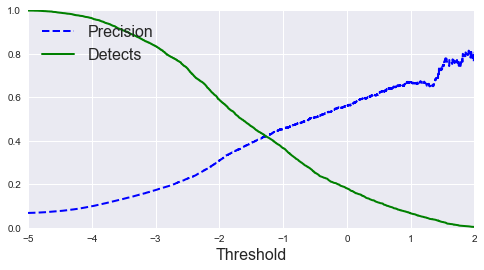

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Detects", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-5, 2])
# save_fig("precision_recall_vs_threshold_plot")
plt.show()

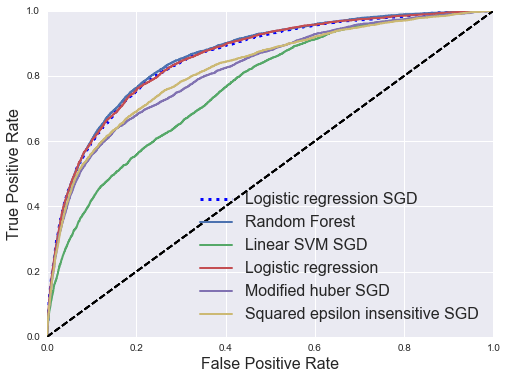

In [25]:
# ROC på test

#Log SGD
LOGmodelGD = SGDClassifier(loss='log', penalty='l2', random_state=101, shuffle=True, max_iter=2000, tol=0.00001)
y_scores = cross_val_predict(LOGmodelGD, X_test_f, y_test_pos, cv=3, method="decision_function")    
fpr_log_gd, tpr_log_gd, thresholds = roc_curve(y_test_pos, y_scores)

#Linear SVM
HmodelGD = SGDClassifier(loss='hinge', penalty='l2', random_state=101, shuffle=True, max_iter=2000, tol=0.00001)
y_scores = cross_val_predict(HmodelGD, X_test_f, y_test_pos, cv=3, method="decision_function")    
fpr_hinge, tpr_hinge, thresholds = roc_curve(y_test_pos, y_scores)

#Modified_huber
MHmodel = SGDClassifier(loss='modified_huber', penalty='l2', random_state=101, shuffle=True, max_iter=2000, tol=0.00001)
y_scores = cross_val_predict(MHmodel, X_test_f, y_test_pos, cv=3, method="decision_function") 
fpr_mh, tpr_mh, thresholds = roc_curve(y_test_pos, y_scores)

#Squared_epsilon_insensitive
SEImodel = SGDClassifier(loss='squared_epsilon_insensitive', penalty='l2', random_state=101, shuffle=True, max_iter=2000, tol=0.00001)
y_scores = cross_val_predict(SEImodel, X_test_f, y_test_pos, cv=3, method="decision_function") 
fpr_sei, tpr_sei, thresholds = roc_curve(y_test_pos, y_scores)

#RF
RFmodel = RandomForestClassifier(random_state=101, n_estimators=100, max_features = 'auto', min_samples_split=100)
y_probas_forest = cross_val_predict(RFmodel, X_test_f, y_test_pos, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_pos, y_scores_forest)

#NearestCentroid
# Nearestmodel = NearestCentroid()
# y_probas_near = cross_val_predict(Nearestmodel, X_test_f, y_test_pos, cv=3, method="predict")
# fpr_near, tpr_near, thresholds_near = roc_curve(y_test_pos, y_probas_near)

#Logistic regression 
LOGmodel = LogisticRegression()
y_scores = cross_val_predict(LOGmodel, X_test_f, y_test_pos, cv=3, method="decision_function") 
fpr_log, tpr_log, thresholds = roc_curve(y_test_pos, y_scores)


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


plt.figure(figsize=(8, 6))
plt.plot(fpr_log_gd, tpr_log_gd, "b:", linewidth=3, label="Logistic regression SGD")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plot_roc_curve(fpr_hinge, tpr_hinge, "Linear SVM SGD")
plot_roc_curve(fpr_log, tpr_log, "Logistic regression")
# plot_roc_curve(fpr_near, tpr_near, "NearestCentroid")
plot_roc_curve(fpr_mh, tpr_mh, "Modified huber SGD")
plot_roc_curve(fpr_sei, tpr_sei, "Squared epsilon insensitive SGD")

plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [30, 50, 100], 'max_features': [8, 16, 32]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(RFmodel, param_grid, cv=3,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_f, y_train)